In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

In [4]:
xs = np.arange(-5, 5, 0.25)
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [5]:
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

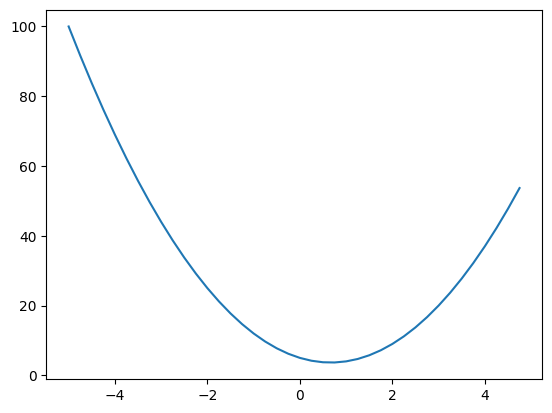

In [6]:
plt.plot(xs, ys)

In [7]:
h = 0.0000000001
x = 2/3
(f(x + h) - f(x))/h

0.0

In [8]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [9]:
h = 0.0001

#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
#a += h
#b += h
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 -d1)/h)


d1 4.0
d2 4.0001
slope 0.9999999999976694


In [10]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
            
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out
    
    def __rmul__(self, other): # other * self
        return self * other
    
    def __truediv__(self, other): # self / other
        return self * other**-1
    
    def __neg__(self): # -self
        return self * -1
    
    def __sub__(self, other): # self - other
        return self + (-other)
    
    def __radd__(self, other): # other + self
        return self + other
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad 
        out._backward = _backward
        
        return out
    
    def backward(self):
    
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

    
#a = Value(2.0, label='a')
#a
#b = Value(-3.0, label='b')
#a.__add__(b)
#a + b
#c = Value(10.0, label='c')
#e = a*b; e.label ='e'
#d = a*b + c
#d = e + c; d.label ='d'
#f = Value(-2.0, label='f')
#d = a.__mul__(b).__add__(c)
#d
#L = d * f; L.label = 'L'
#L

In [11]:
#a = Value(2.0)
#b = Value(4.0)
#a / b
#a.exp()
#a - b

In [12]:
#d._prev

In [13]:
#d._op

In [14]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it 
            dot.edge(uid + n._op, uid)
            
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot  

In [15]:
#L.grad = 1.0
#f.grad = 4.0
#d.grad = -2.0
#c.grad = -2.0
#e.grad = -2.0
#a.grad = -2.0 * -3.0
#b.grad = -2.0 * 2.0

In [16]:
#draw_dot(L)

In [17]:
#a.data += 0.01 * a.grad
#b.data += 0.01 * b.grad
#c.data += 0.01 * c.grad
#f.data += 0.01 * f.grad

#e = a * b
#d = a + c
#L = d * f

#print(L.data)

In [18]:
#def lol():
    
#    h = 0.001
    
#    a = Value(2.0, label='a')
    #a
#    b = Value(-3.0, label='b')
    #a.__add__(b)
    #a + b
#    c = Value(10.0, label='c')
#    e = a*b; e.label ='e'
    #d = a*b + c
#    d = e + c; d.label ='d'
#    f = Value(-2.0, label='f')
    #d = a.__mul__(b).__add__(c)
    #d
#    L = d * f; L.label = 'L'
#    L1 = L.data
    
#    a = Value(2.0 , label='a')
    #a
    #a.data += h
#    b = Value(-3.0, label='b')
    #b.data += h
    #a.__add__(b)
    #a + b
#    c = Value(10.0, label='c')
    #c.data += h
#    e = a*b; e.label ='e'
    #e.data += h
    #d = a*b + c
#    d = e + c; d.label ='d'
#    d.data += h
#    f = Value(-2.0, label='f')
    #d = a.__mul__(b).__add__(c)
    #d
#    L = d * f; L.label = 'L'
#    L2 = L.data
    
#    print((L2 - L1)/h)
    
#lol()

In [19]:
#plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [20]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2' 
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

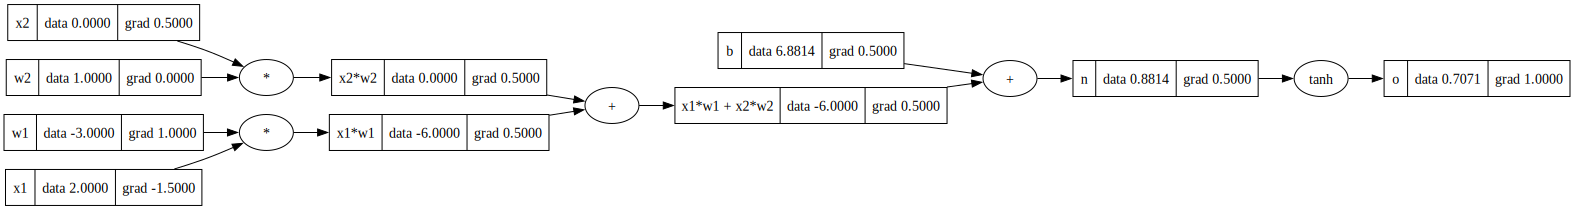

In [21]:
draw_dot(o)

In [22]:
#o.backward()

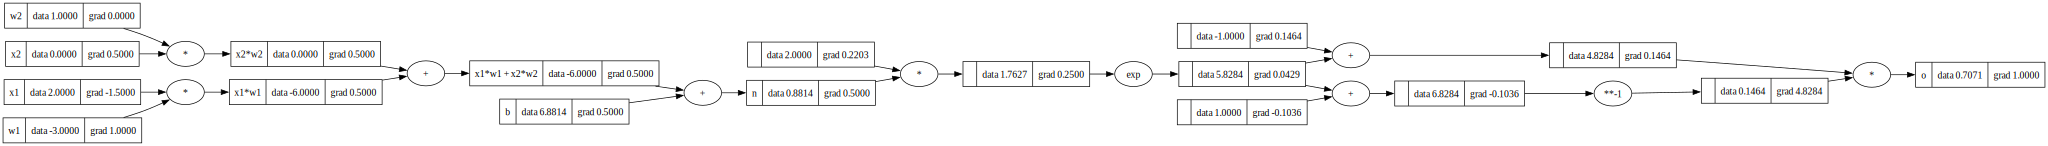

In [23]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [24]:
#topo = []
#visited = set()
#def build_topo(v):
#    if v not in visited:
#        visited.add(v)
#        for child in v._prev:
#            build_topo(child)
#    topo.append(v)
#build_topo(o)
#topo

In [25]:
#o.grad = 1.0

In [26]:
#o._backward()

In [27]:
#n._backward()

In [28]:
#b._backward()

In [29]:
#x1w1x2w2._backward()

In [30]:
#x2w2._backward()
#x1w1._backward()

In [31]:
#x1.grad = w1.data * x1w1.grad
#w1.grad = x1.data * x1w1.grad

In [32]:
#x2.grad = w2.data * x2w2.grad
#w2.grad = x2.data * x2w2.grad

In [33]:
#x1w1.grad = 0.5
#x2w2.grad = 0.5

In [34]:
#x1w1x2w2.grad = 0.5
#b.grad = 0.5

In [35]:
#n.grad = 0.5

In [36]:
#o.grad = 1.0

In [37]:
# o = tanh(n)
# do/dn = 1 - o**2
#1 - o.data**2

In [38]:
#a = Value(3.0, label='a')
#b = a + a; b.label = 'b'
#b.backward()
#draw_dot(b)

In [39]:
#a = Value(-2.0, label='a')
#a = Value(3.0, label='b')
#d = a * b; d.label = 'd'
#e = a + b; e.label = 'e'
#f = d * e; f.label = 'f'

#f.backward()

#draw_dot(f)